primeiro vamos improtar as bibliotecas para ver checar como estão as fotos

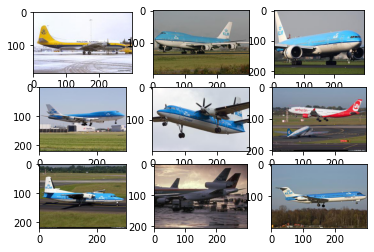

In [5]:
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'raw-images/klm/'
# plot first few images
for (i,filename) in enumerate(listdir(folder)):
    # definir subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    # load image pixels
    path = folder + filename
    image = imread(path)
    # plot raw pixel data
    pyplot.imshow(image)
    if i >= 8:
        break
# show the figure
pyplot.show()

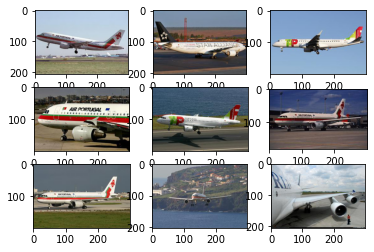

In [6]:
folder = 'raw-images/tap/'
# plot first few images
for (i,filename) in enumerate(listdir(folder)):
    # definir subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    # load image pixels
    path = folder + filename
    image = imread(path)
    # plot raw pixel data
    pyplot.imshow(image)
    if i >= 8:
        break
# show the figure
pyplot.show()

já fica claro que algumas fotos tem tamanhos diferentes (o que é esperado dado a origem das mesmas) e em algumas será impossivel de indentificar a empresa (o que é parte do jogo)

vamos mover os diretorios com o intuito de separar em train e test

agora nossos repositorios estão preparados para receber nosso modelo

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

a ideia é simples: vamos usar um modelo vgg16, pré-treinada, sem a ultima camada, assim precisamos treinar o nosso modelo para aprender a usar as features aprendidas pelo vgg16 pra o nosso modelo

In [2]:
# define cnn model
def model_simple():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [3]:
# define cnn model
def model_vgg():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # configurar os layers carregados para não serem treinados
    for layer in model.layers:
        layer.trainable = False
    # adicionar um novo leayer de classificação
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # definir o modelo
    model = Model(inputs=model.inputs, outputs=output)
    # compilar o modelo
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

vamos preparar algumas estatisticas que serão uteis durante nosso aprendizado

In [7]:
from matplotlib import pyplot

# plot as curvas de learning rate
def summarize_diagnostics(history,arch,acc):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    pyplot.savefig('plots/'+ str(acc) + '.' + arch + '_plot.png')
    pyplot.close()

In [10]:
# run the test harness for evaluating a model
def run_test_harness():
    # define model
    arch = 'model_vgg'
    model = eval(arch + '()')
#    # create data generator
#    datagen = ImageDataGenerator(featurewise_center=True)
#    # specify imagenet mean values for centering
#    datagen.mean = [123.68, 116.779, 103.939]
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterator
    train_it = datagen.flow_from_directory('dataset/train/',
        class_mode='binary', batch_size=64, target_size=(224, 224))
    test_it = datagen.flow_from_directory('dataset/test/',
        class_mode='binary', batch_size=64, target_size=(224, 224))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=4, verbose=1)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    
    #salva os pesos do modelo
    model.save('weights/'+ str(acc) + '.' + arch+'.h5')
    
    # learning curves
    summarize_diagnostics(history,arch,str(acc))
    

In [11]:
# entry point, run the test harness
run_test_harness()

Found 1792 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 28 steps, validate for 4 steps
Epoch 1/4
28/28 [==============================] - 22s 791ms/step - loss: 0.6325 - accuracy: 0.6479 - val_loss: 0.4743 - val_accuracy: 0.8173
Epoch 2/4
28/28 [==============================] - 16s 568ms/step - loss: 0.4021 - accuracy: 0.8449 - val_loss: 0.3312 - val_accuracy: 0.8750
Epoch 3/4
28/28 [==============================] - 16s 570ms/step - loss: 0.2866 - accuracy: 0.8990 - val_loss: 0.2697 - val_accuracy: 0.9087
Epoch 4/4
28/28 [==============================] - 68s 2s/step - loss: 0.2304 - accuracy: 0.9191 - val_loss: 0.2208 - val_accuracy: 0.9183
  ...
    to  
  ['...']
4/4 [==============================] - 14s 3s/step - loss: 0.2208 - accuracy: 0.9183
> 91.827
